In [1]:
from os.path import exists
from os import system
import sys
import os
import datetime as DT
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.animation as animation

In [22]:
class TimeManagement:
  def __init__(self, reloadTime, root_path, save_path, colors, export = True):
    if(root_path is None):
      root_path = os.getcwd()
    if(colors is None):
      colors = {"Game": "blue", "Mirror":"green", "Master": "red", "Browser": "orange", "Other":"yellow", "Social":"purple"}
    
    self.root_path = root_path
    self.save_path = save_path
    self.reloadTime = reloadTime
    self.colors = colors
    self.export = export

    return

In [23]:
# Import & Preprocess Data
# ==================================================================
def import_and_preprocess(self, fd, td):
  if self.export:
    self.export_app_data(fd, td) # debug!
  app, process_tags = self.load_files()
  process_tags = self.tagging(app, process_tags)
  app = self.merge_tags(app, process_tags)
  app = self.create_effective_day(app)
  
  self.app = app

TimeManagement.import_and_preprocess = import_and_preprocess

In [24]:
def month_import_and_preprocess(self, month):
  today = DT.date.today()
  fd = today.replace(month=month, day=1)
  td = today.replace(month=month+1, day=1) - DT.timedelta(days=1)

  self.import_and_preprocess(fd, td)

def export_app_data(self, fd, td):
  app_path = self.root_path + "/data/applications.csv"
  system("D:/ManicTime/mtc export ManicTime/Applications " + app_path + " /fd:" + str(fd) + " /td:" + str(td))
  return

TimeManagement.month_import_and_preprocess = month_import_and_preprocess
TimeManagement.export_app_data = export_app_data

In [25]:
def load_files(self):
  # Application file from ManicTime
  print(f"load_files: {self.root_path + "/data/applications.csv"}")
  app = pd.read_csv(self.root_path + "/data/applications.csv", delimiter=",")
  print(app)
  app.Start = pd.to_datetime(app.Start)
  app.End = pd.to_datetime(app.End)
  app.Duration = pd.to_timedelta(app.Duration)
  # app["Day"] = app.Start.dt.floor("d")

  # Read in or Create Processed Tags Table
  process_tags_path = self.root_path + "/data/process_tags.csv"
  if (exists(process_tags_path)):
    process_tags = pd.read_csv(process_tags_path, index_col=0)
  else:
    process_tags = pd.DataFrame(columns=["Process", "Tag"])
  return app, process_tags

TimeManagement.load_files = load_files

In [26]:
def tagging(self, app, process_tags):
  # Fill the missing Tags!
  skipped = []
  
  # Go through application table, look for things that are no in the Process Tags list AND are not a Firefox Window or VSC Window 
  no_need = ["Firefox Developer Edition", "Visual Studio Code"]
  for process in app.Process.unique():
    if((not process_tags.Process.isin([process]).any()) and (process not in no_need)):
      tag = input(process + "\nWhat tag is this process (1-Game, 2-Mirror, 3-Master, 4-Other, else-Skip): ")

      if(tag == "1"):
        process_tags.loc[process_tags.shape[0]] = [process, "Game"]
      elif(tag == "2"):
        process_tags.loc[process_tags.shape[0]] = [process, "Mirror"]
      elif(tag == "3"):
        process_tags.loc[process_tags.shape[0]] = [process, "Master"]
      elif(tag == "4"):
        process_tags.loc[process_tags.shape[0]] = [process, "Other"]
      else:
        skipped.append(process)
  
  if(len(skipped) > 0):
    print("Skipped tagging on: ", skipped)
  
  process_tags.sort_values(by=["Tag", "Process"], inplace=True)
  process_tags.reset_index(drop=True, inplace=True)

  # Save any changes done to the Processed Tags Table
  process_tags.to_csv(self.root_path + "/data/process_tags.csv")
  return process_tags

TimeManagement.tagging = tagging

In [27]:
def merge_tags(self, app, process_tags):
  app = pd.merge(app, process_tags, how="left", left_on="Process", right_on="Process")

  # Special Case VSC
  for i, row in app[app.Process == "Visual Studio Code"].iterrows():
    if(any(x in row.Name for x in ["Passenger_Seo", "matar (Workspace)"])):
      app.at[i, "Tag"] = "Master"
    else:
      app.at[i, "Tag"] = "Mirror"
  
  # Special Case Firefox
  for i, row in app[app.Process == "Firefox Developer Edition"].iterrows():
    if(any(x in row.Name for x in ["YouTube", "Reddit", "Twitch", "Netflix", "Prime Video"])):
      app.at[i, "Tag"] = "Social"
    elif(any(x in row.Name for x in ["ChatGPT", "python", "tensorflow", "TensorFlow", "keras", "Zoom", "TU Berlin"])):
      app.at[i, "Tag"] = "Master"
    elif(any(x in row.Name for x in ["Unity", "unity", "c#", "C#"])):
      app.at[i, "Tag"] = "Mirror"
    else:
      #! Sadly there is no other way to determine what task I was actually doing so everything else goes to Browser
      app.at[i, "Tag"] = "Browser"
  
  #? These are all the websites that needed to be stored as "Browser" since I dont know where to assign them to
  # other = app.loc[(app.Process == "Firefox Developer Edition") & (app.Tag == "Browser"), "Name"].unique()
  # pprint(other)
  return app

TimeManagement.merge_tags = merge_tags

In [28]:
def create_effective_day(self, app):
  threshold_hour = 7 #7AM

  # Create a new column 'Effective_Day' by shifting dates back for any time before threshold
  app['Effective_Day'] = app['Start'].apply(lambda x: x - DT.timedelta(days=1) if x.hour < threshold_hour else x)
  app['Effective_Day'] = app['Effective_Day'].dt.floor('D')  # Only keep the date part

  return app

TimeManagement.create_effective_day = create_effective_day

In [29]:
def summary(self, td):
  # Week summary
  fig = plt.figure(figsize=(100, 100))
  gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.1, top=0.9, bottom=0.1)

  # Line Chart
  ax = self.line_chart(self.app, td, ax=plt.subplot(gs[0,:]))
  ax.set_title("Today's recap")

  # Pie Charts
  self.pie_chart(self.app, td - DT.timedelta(days=2), plt.subplot(gs[1,0]))
  ax = self.pie_chart(self.app, td - DT.timedelta(days=1), plt.subplot(gs[1,1]))
  self.pie_chart(self.app, td, plt.subplot(gs[1,2]))
  ax.set_title("3day recap")

  # Bar Plot
  week_ago = td - DT.timedelta(days=7)
  ax = self.bar_chart(self.app, week_ago, td, ax=plt.subplot(gs[2,:]))
  ax.set_title("Week recap")

  fig.canvas.manager.set_window_title('Time Management')
  fig.set_size_inches(10, 9, forward=True) # w, h
  
  # plt.tight_layout()
  # fig.tight_layout()
  plt.savefig(self.save_path + "/summary.jpg")
  return

TimeManagement.summary = summary

In [30]:
def week_summary(self, td = DT.date.today()):
  # Week summary
  fig = plt.figure(figsize=(100, 100))
  gs = gridspec.GridSpec(7, 2, figure=fig)

  for i in range(7):
    # Line Chart
    date = td - DT.timedelta(days=7-i)
    ax = self.line_chart(self.app, date, ax=plt.subplot(gs[i, 0]))
    ax.sharex = ax
    ax.legend().set_visible(i == 0) 

    # Pie Charts
    ax = self.pie_chart(self.app, date, plt.subplot(gs[i, 1]))

  fig.canvas.manager.set_window_title('Time Management')
  fig.set_size_inches(10, 13, forward=True)
  plt.tight_layout()
  fig.tight_layout()
  plt.savefig(self.save_path + "/week_report.jpg")

TimeManagement.week_summary = week_summary

In [31]:
def three_week_summary(self, td):
  rows = 4
  cols = 7
  
  fig = plt.figure(figsize=(100, 100))
  plt.rcParams.update({'font.size': 22})
  gs = gridspec.GridSpec(rows, cols, figure=fig, hspace=0.1, top=0.9, bottom=0.1)
  # gs = gridspec.GridSpec(rows, cols, figure=fig)

  used_axes = set()

  # Pie Charts
  # ==========
  # monday 2 weeks ago
  fd = td - DT.timedelta(days=td.weekday()+14)

  for i in range(21):
    date = fd + DT.timedelta(days=i)

    # ax = self.line_chart(self.app, date, ax=plt.subplot(gs[int(i/cols), i%cols]))
    ax = self.pie_chart(self.app, date, ax=plt.subplot(gs[int(i/cols), i%cols]))
    
    weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    weekday = weekday[date.weekday()]

    if weekday == "Mon" and i/7 == 0:
      ax.legend = True
      # ax.legend(list(self.colors.keys()), loc='center left', bbox_to_anchor=(-0.5, 0.5))
    
    if ax is not None:
      ax.set_title(weekday + " " + str(date))
      used_axes.add((int(i / cols), i % cols))

  # Line Charts
  # ==========
  for i in range(3):  # One line chart per day
    date = td - DT.timedelta(days=2-i)
    ax = self.line_chart(self.app, date, ax=plt.subplot(gs[3, 2 * i:2 * (i + 1)]))  # Allocate equal space
    
    weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    weekday = weekday[date.weekday()]

    if ax is not None:
      ax.legend().set_visible(i == 0) 
      ax.set_title(weekday + " " + str(date))
      used_axes.update({(3, j) for j in range(2 * i, 2 * (i + 1))})
  
  for row in range(rows):
    for col in range(cols):
      if (row, col) not in used_axes:
        ax = plt.subplot(gs[row, col])
        ax.axis('off')  # Turn off the axis for unused subplots


  fig.canvas.manager.set_window_title('Time Management')
  fig.set_size_inches(50, 25, forward=True) # w, h

  # plt.tight_layout()
  # fig.tight_layout()
  plt.savefig(self.save_path + "/three_week_summary.jpg")
  return

TimeManagement.three_week_summary = three_week_summary

In [32]:
def month_view(self, month):
  rows = 5
  cols = 7
  
  fig = plt.figure(figsize=(100, 100))
  plt.rcParams.update({'font.size': 22})
  gs = gridspec.GridSpec(rows, cols, figure=fig, hspace=0.1, top=0.9, bottom=0.1)
  # gs = gridspec.GridSpec(rows, cols, figure=fig)

  used_axes = set()
  fd = DT.date.today().replace(month=month, day=1)
  td = (DT.date.today().replace(month=month+1, day=1) - DT.timedelta(days=1))
  
  days = td.day
  for i, j in enumerate(range(fd.weekday(), days+1)):
    date = fd + DT.timedelta(days=i)

    # ax = self.line_chart(self.app, date, ax=plt.subplot(gs[int(i/cols), i%cols]))
    ax = self.pie_chart(self.app, date, ax=plt.subplot(gs[int(j/cols), j%cols]))
    
    weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    weekday = weekday[date.weekday()]
    
    if ax is not None:
      ax.set_title(weekday + " " + str(date))
      used_axes.add((int(i / cols), i % cols))
  
  for row in range(rows):
    for col in range(cols):
      if (row, col) not in used_axes:
        ax = plt.subplot(gs[row, col])
        ax.axis('off')  # Turn off the axis for unused subplots
  
  fig.canvas.manager.set_window_title('Time Management')
  fig.set_size_inches(50, 25, forward=True) # w, h
  # plt.tight_layout()
  # fig.tight_layout()
  print("Finished Month View " + str(month))
  plt.savefig(self.save_path + "/month_view_" + str(month) + ".jpg")
  return

TimeManagement.month_view = month_view

In [33]:
def line_chart(self, app, day, ax=None):
  day = pd.to_datetime(day)
  grouped_df = app[app["Effective_Day"]== day]

  unique_tags = grouped_df['Tag'].unique()

  # Create new DataFrame with 0 duration and End equal to minimum Start for each tag
  new_entries = pd.DataFrame({
      'Tag': unique_tags,
      'Duration': pd.to_timedelta(np.zeros(len(unique_tags)), unit='s'),
      'End': [grouped_df[grouped_df['Tag'] == tag]['Start'].min() for tag in unique_tags],
      'Start': [grouped_df[grouped_df['Tag'] == tag]['Start'].min() for tag in unique_tags]
  })

  grouped_df = grouped_df.append(new_entries, ignore_index=True)
  
  grouped_df = grouped_df.groupby(["Tag", "End"])["Duration"].sum().reset_index()
  grouped_df["Duration"] = grouped_df["Duration"].dt.total_seconds()/3600

  grouped_df.sort_values(by="End", inplace=True)
  grouped_df["Cumulative Duration"] = grouped_df.groupby("Tag")["Duration"].cumsum()
  
  pivot_df = grouped_df.pivot(index="End", columns="Tag", values="Cumulative Duration")
  pivot_df = pivot_df.ffill()

  if(not pivot_df.empty):
    ax = pivot_df.plot(kind="line", grid=True, color=self.colors, figsize=(10, 5), ax=ax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.set_xlabel("")
    ax.set_ylim(bottom=0)

    ax.legend(loc='upper left')
    return ax
  else:
    return None
  
TimeManagement.line_chart = line_chart

In [34]:
def pie_chart(self, app, day, full_day = 13, ax=None):
  day = pd.to_datetime(day)
  grouped_df = app.groupby(["Effective_Day", "Tag"])["Duration"].sum().reset_index()
  grouped_df = grouped_df[grouped_df["Effective_Day"] == day]
  
  grouped_df["Duration"] = grouped_df["Duration"].dt.total_seconds()/3600
  grouped_df["Effective_Day"] = pd.to_datetime(grouped_df["Effective_Day"])

  grouped_df = grouped_df.set_index("Tag", drop=True)

  grouped_df.sort_values(by="Tag", inplace=True)
  
  if grouped_df["Duration"].sum() > 0:
    grouped_df.loc["None"] = {"Effective_Day": day , "Duration": full_day - grouped_df["Duration"].sum()}
  
  colors = [self.colors[tag] for tag in grouped_df.index]

  def label_func(pct, allvals):
    absolute = pct/100.*np.sum(allvals)
    return "{:.1f} h".format(absolute)
  
  if(not grouped_df.empty):
    ax = grouped_df.plot(
      kind="pie",
      y="Duration",
      legend=False,
      labels=None,
      title=day.strftime("%a %d.%m"), 
      ylabel="", 
      autopct=lambda pct: label_func(pct, grouped_df["Duration"],),
      ax=ax,
      colors=colors,
      startangle=90)
  
    return ax
  else:
    return None

TimeManagement.pie_chart = pie_chart

In [35]:
def bar_chart(self, app, start_date=None, end_date=None, ax=None):
  start_date = pd.to_datetime(start_date)
  end_date = pd.to_datetime(end_date)

  grouped_df = app.groupby(["Effective_Day", "Tag"])["Duration"].sum().reset_index()

  grouped_df["Effective_Day"] = pd.to_datetime(grouped_df["Effective_Day"])

  if(start_date is not None):
    grouped_df = grouped_df[grouped_df["Effective_Day"] > start_date]
  if(end_date is not None):
    grouped_df = grouped_df[grouped_df["Effective_Day"] <= end_date]
  
  # grouped_df["Effective_Day"] = grouped_df["Effective_Day"].dt.strftime("%a %d-%m")
  grouped_df["Duration"] = grouped_df["Duration"].dt.total_seconds()/3600

  pivot_df = grouped_df.pivot(index="Effective_Day", columns="Tag", values="Duration")
  pivot_df.sort_index()
  pivot_df.index = pivot_df.index.strftime("%a %d-%m")

  ax = pivot_df.plot(kind="bar", stacked=False, figsize=(10, 5), grid=True, color=self.colors, ax=ax)
  ax.set_ylabel("")
  ax.set_xlabel("")
  ax.get_legend().remove()
  plt.xticks(rotation=45)
  return ax

TimeManagement.bar_chart = bar_chart

In [36]:
def update_data(self):
  self.export_app_data()
  self.load_files()
  self.tagging()
  self.merge_tags()

TimeManagement.update_data = update_data

In [37]:
def continuous_day_chart(self):
  fig = plt.figure(figsize=(10, 5))
  fig.canvas.manager.set_window_title('Day Time Management')
  gs = gridspec.GridSpec(1, 1, figure=fig)

  self.day_today = DT.date.today()

  self.day_ax = plt.subplot(gs[0,0])
  ani = animation.FuncAnimation(fig, self.update_day_chart, interval=self.reloadTime*1000)
  plt.show()
  return

TimeManagement.continuous_day_chart = continuous_day_chart

In [38]:

def update_day_chart(self, *args):
  self.update_data()
  self.day_ax.clear()
  self.line_chart(self.day_today, ax=self.day_ax)
  return

TimeManagement.update_day_chart = update_day_chart

load_files: /Users/matar/Documents/PugiosDocuments/OwnProjects/TimeManagement/data/applications.csv
                                                   Name  \
0     dataset.py - Passenger_Seo (Workspace) - Visua...   
1     ● run_model.ipynb - Passenger_Seo (Workspace) ...   
2                 06.05.2025 - Vault - Obsidian v1.8.10   
3                 08.05.2025 - Vault - Obsidian v1.8.10   
4     ● run_model.ipynb - Passenger_Seo (Workspace) ...   
...                                                 ...   
6989                 ChatGPT - Mental — Mozilla Firefox   
6990              Einreise in die USA — Mozilla Firefox   
6991  Mental - Anime and Productivity Tips — Mozilla...   
6992                 ChatGPT - Mental — Mozilla Firefox   
6993                 ChatGPT - Mental — Mozilla Firefox   

                            Start                          End Duration  \
0     2025-05-09T00:00:00.0000000  2025-05-09T00:00:04.0000000  0:00:04   
1     2025-05-09T00:00:04.0000000  2025-0

KeyError: 'Main'

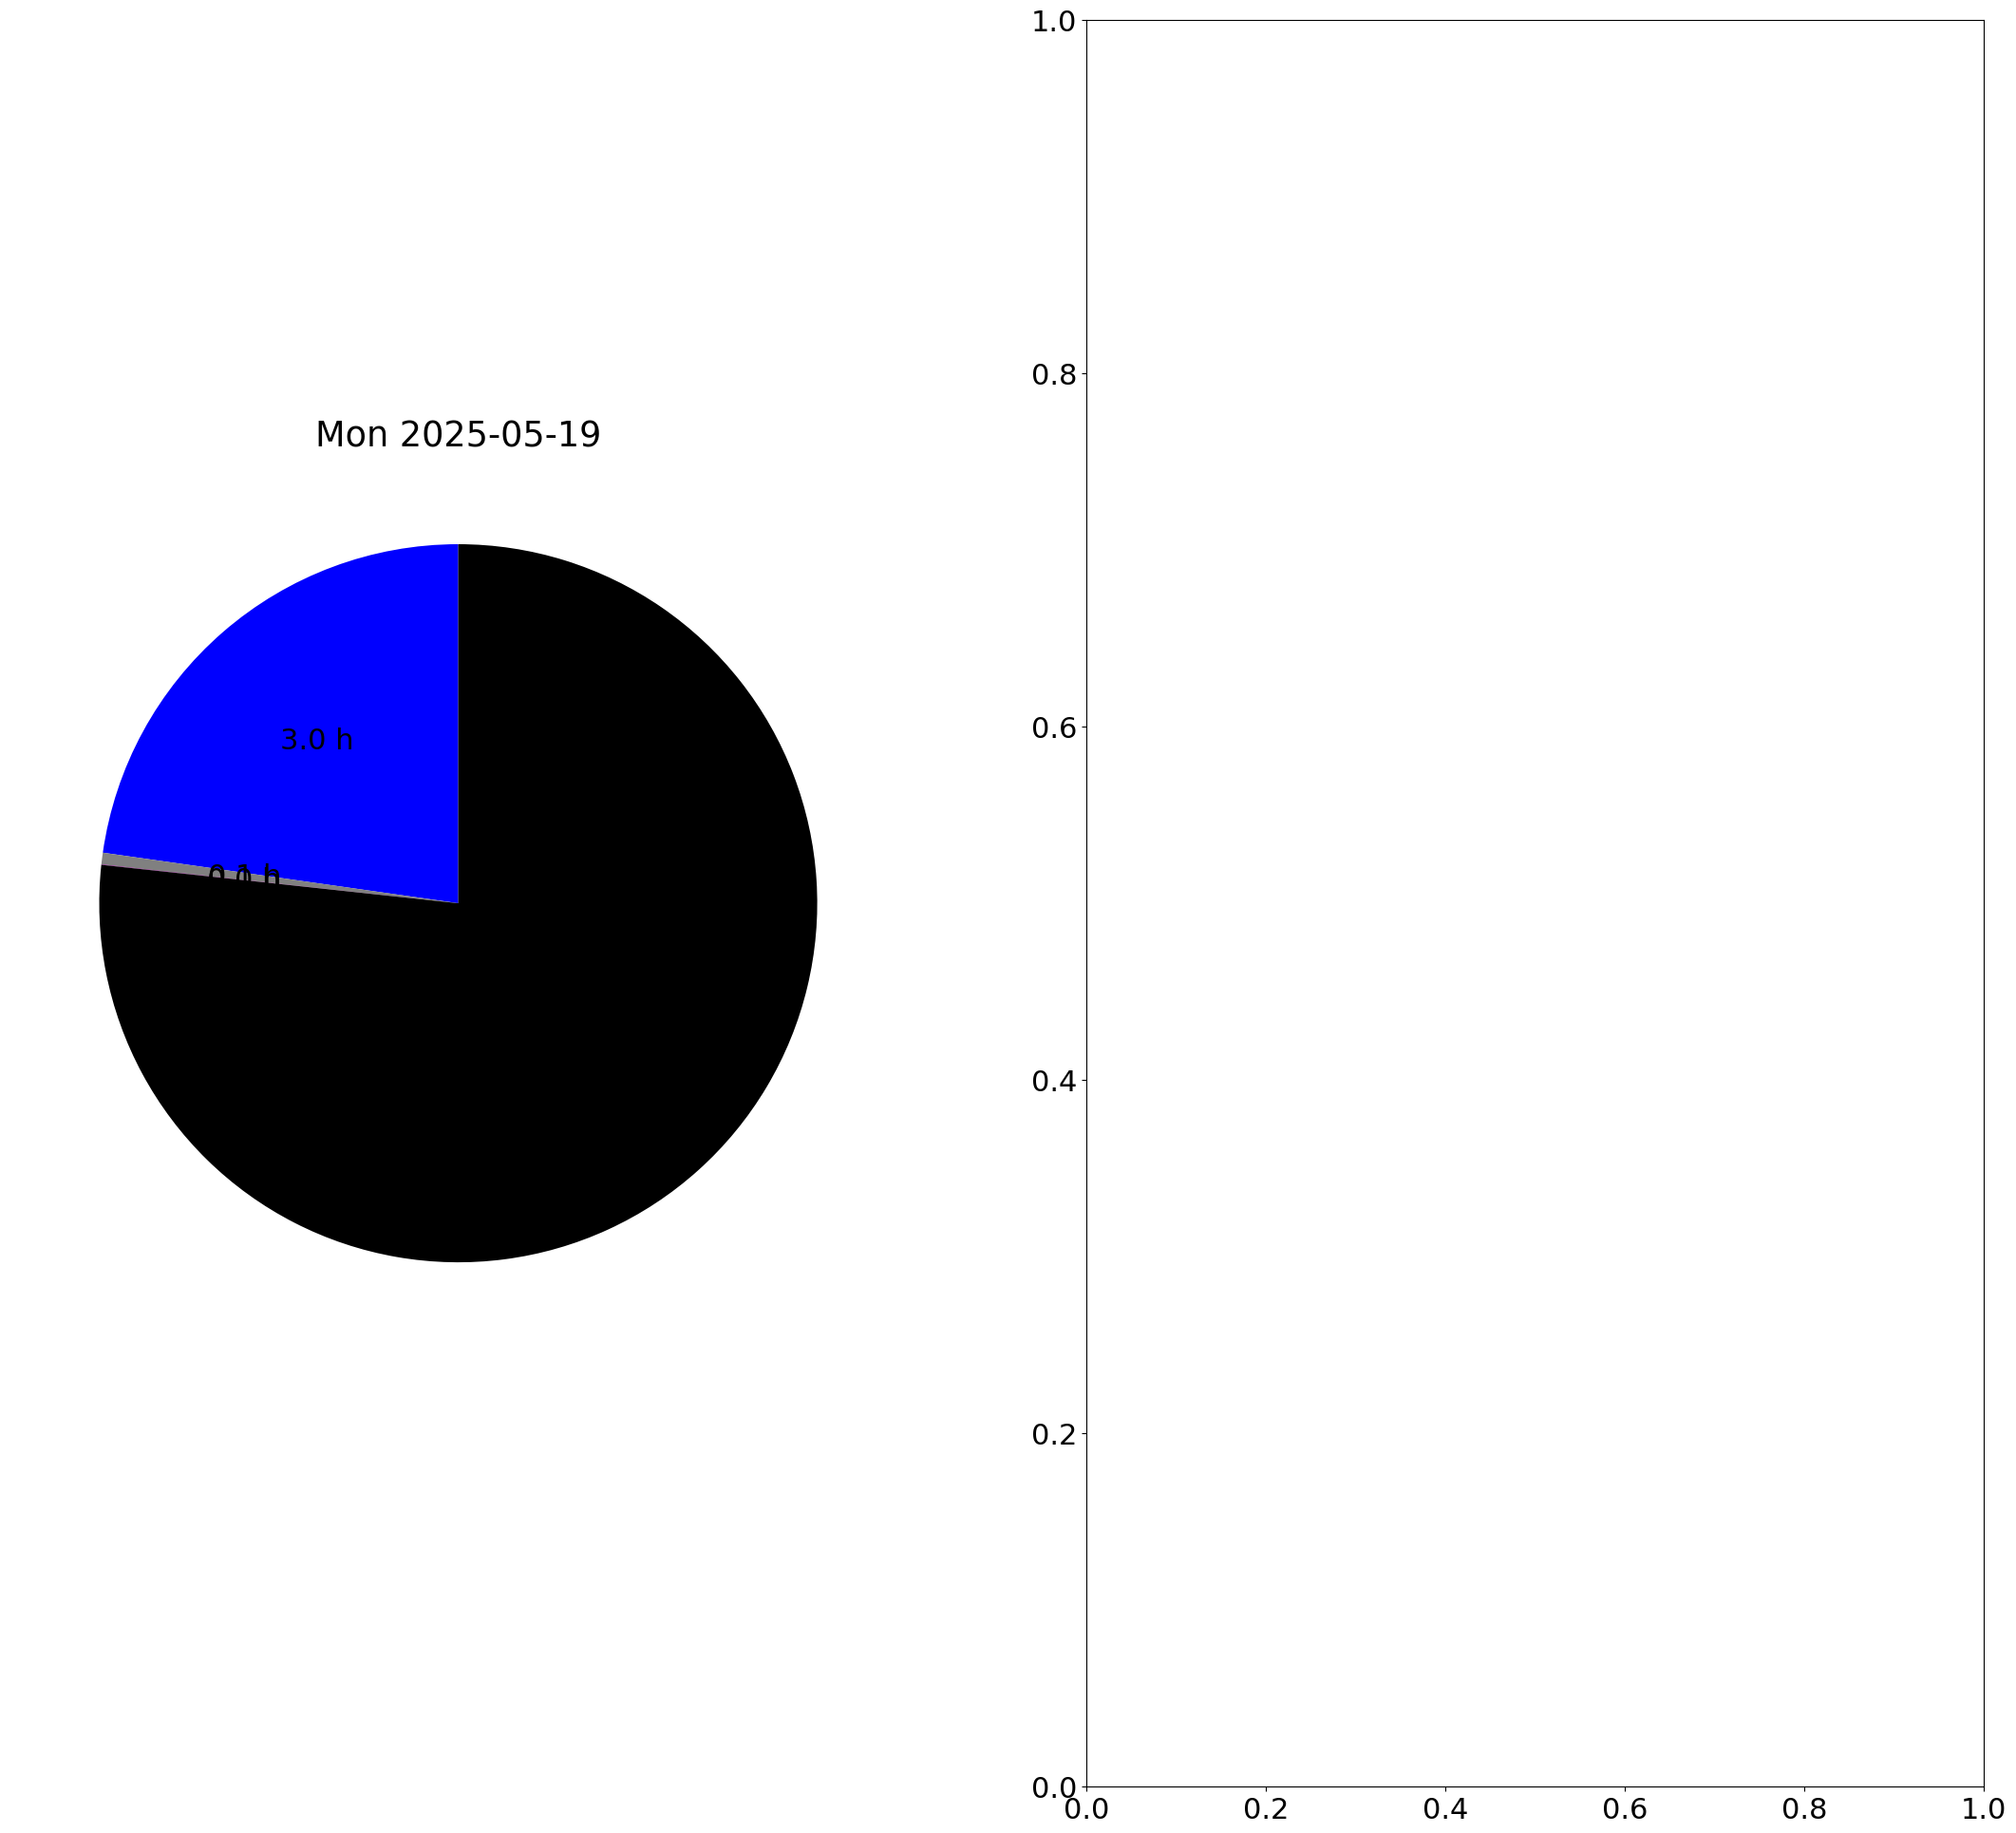

In [39]:
# Configs:
td = DT.date.today() # to date
fd = td - DT.timedelta(days=24) # from date
reloadTime = 600
root_path = "/Users/matar/Documents/PugiosDocuments/OwnProjects/TimeManagement"
save_path = root_path
colors = {"Game": "blue", "Mirror":"green", "Master": "red", "Browser": "orange", "Other":"grey", "Social":"purple", "None": "black"}
export = True # False = Debug, True = Download application again
month = 11

for arg in sys.argv:
  if arg.startswith("-sp"):
    save_path = arg.split("=")[1]
  elif arg.startswith("-debug"):
    export = False

tm = TimeManagement(reloadTime, root_path, save_path, colors, export)


# Create Report
# =============

# 3 Week Report
tm.import_and_preprocess(fd, td)
tm.three_week_summary(td)

# Month Report
tm.month_import_and_preprocess(month)
tm.month_view(month)

# self.summary(td)
# self.week_summary(td)
tm.continuous_day_chart()

Checking My Time Managemet

In [ ]:
 
  # Graph Assembly
  # ==================================================================
  
  # Graph Creation
  # ==================================================================

  # Other
  # ==================================================================

